In [30]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
from osgeo import gdal
from datetime import datetime
import salem
import math
from salem import *

In [31]:
fl_path = '/home/pelto/Desktop/ice_flux/Conrad/'
gpr_path = '/home/pelto/GIS/GPR/ComparisonData/conrad/'
# vdir ='img1_20170521__img2_20180426_vmap_10m_35px_spm2/'#'img1_20160417__img1_20170521_vmap_10m_35px_spm2/' #'img1_20160417__img1_20170521_vmap_5.0m_35px_spm2/'
# vdir1 = '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/bedem5_spm2/' + vdir
path = '/media/pelto/serac_backup/Lidar_DEMs/bare_earth_BC_hydro/conrad/'


In [32]:
f_in = 'conrad_stakes.csv'    
stakes = pd.read_csv('/home/pelto/Desktop/ice_flux/Conrad/' + f_in)
stakes[0:10]

,survey_no,year,date,name,new_old,surv_name,E,N,Elev
0,1,2015,2015-07-16,NaN,NaN,CONK2,505177.5,5631146.0,1889.4
1,1,2015,2015-07-16,NaN,NaN,CONKJ,504922.8,5630804.0,2022.4
2,1,2015,2015-07-16,CST2,new,CONK3,505188.8,5630627.0,2077.3
3,1,2015,2015-07-16,NaN,NaN,CONKWX,505460.7,5630350.0,2125.8
4,1,2015,2015-07-16,NaN,NaN,CONKWX2,505544.5,5630157.0,2148.2
5,1,2015,2015-07-16,NaN,NaN,CONKIN,505215.9,5629867.0,2209.1
6,1,2015,2015-07-16,NaN,NaN,CONKINK,505278.0,5629838.0,2206.0
7,1,2015,2015-07-16,CST3,NaN,CONKINK3,505542.8,5629937.0,2177.8
8,1,2015,2015-07-16,CST3,new,CONKINK3A,505544.7,5629931.0,2181.7
9,1,2015,2015-07-16,NaN,NaN,CONKINKJ,505475.7,5630744.0,2089.4


In [33]:
Dis=pd.DataFrame({})
for num in np.arange(2,7,1):  
    T=np.array(stakes[(stakes.survey_no==num)&(stakes.new_old=='old')].name) ##add in 'both'
    for n in T:
        try:
            x=stakes[(stakes.survey_no==num-1) & (stakes.name==n) & (stakes.new_old=='new')].index[0] ##add in 'both'
        except:
            continue
        else:
            G=stakes[stakes.index==x]
            if np.array(G.new_old=='new')[0]:
                eNEW=float(G.E)
                nNEW=float(G.N)
                
                eOLD=float(stakes[(stakes.name==n) & (stakes.survey_no==num)&(stakes.new_old=='old')].E)
                nOLD=float(stakes[(stakes.name==n) & (stakes.survey_no==num)&(stakes.new_old=='old')].N)
                
                ##calculate stake displacement (meters) 
                distance = np.sqrt((eNEW - eOLD)**2 + (nNEW - nOLD)**2)
                dist_x = eOLD - eNEW  
                dist_y = nOLD - nNEW  
              
                
                ##calculate time (days) between surveys and then velocity (m/yr)
                start_DATE = (stakes[(stakes.name==n) & (stakes.survey_no==num-1)&(stakes.new_old=='new')].date)
                end_DATE   = (stakes[(stakes.name==n) & (stakes.survey_no==num)&(stakes.new_old=='old')].date)
                S_DT=datetime.strptime(np.array(start_DATE)[0],'%Y-%m-%d')
                E_DT=datetime.strptime(np.array(end_DATE)[0],'%Y-%m-%d')
                diff_days  = (E_DT - S_DT).days 
                V = float((distance / diff_days) * 365.)
                
                u = float((dist_x / diff_days) * 365.) 
                v = float((dist_y / diff_days) * 365.) 

                ##calculate azimuth  
    #           https://gis.stackexchange.com/questions/108547/how-to-calculate-distance-azimuth-and-dip-from-two-xyz-coordinates
                az = math.degrees(math.atan2((eOLD - eNEW), (nOLD - nNEW))) 
                         
                Ele=float(stakes[(stakes.name==n) & (stakes.survey_no==num)&(stakes.new_old=='old')].Elev)
                year=int(stakes[(stakes.name==n) & (stakes.survey_no==num)&(stakes.new_old=='old')].year)
                
                Dis=Dis.append({'Name':n,'eNew':(eNEW), 'nNew':(nNEW),'eOld':(eOLD),'nOld':(nOLD),
                                'Elevation':Ele,'Year':year, 'Displacement':distance,'time_days':diff_days, 
                                'velocity':V, 'azimuth': az, 'u':u, 'v':v}, ignore_index=True)
Dis                

,Displacement,Elevation,Name,Year,azimuth,eNew,eOld,nNew,nOld,time_days,u,v,velocity
0,3.047950,1876.8,CST0,2015.0,48.990913,505139.8,505142.100,5631227.0,5631229.000,52.0,16.144231,14.038462,21.394265
1,6.621178,1968.0,CST1,2015.0,25.016893,504987.4,504990.200,5630982.0,5630988.000,52.0,19.653846,42.115385,46.475577
2,3.720215,2073.4,CST2,2015.0,-36.253838,505188.8,505186.600,5630627.0,5630630.000,52.0,-15.442308,21.057692,26.113048
3,11.605602,2174.6,CST3,2015.0,-18.591068,505544.7,505541.000,5629931.0,5629942.000,52.0,-25.971154,77.211538,81.462399
4,11.605602,1964.7,CST1,2016.0,18.591068,504991.1,504994.800,5630988.0,5630999.000,288.0,4.689236,13.940972,14.708489
5,5.381450,1874.8,CST0,2016.0,41.987212,505142.6,505146.200,5631227.0,5631231.000,288.0,4.562500,5.069444,6.820240
6,25.663983,2172.9,CST3,2016.0,-13.061551,505540.9,505535.100,5629941.0,5629966.000,288.0,-7.350694,31.684028,32.525533
7,1.220656,1871.1,CST0,2016.0,34.992020,505139.4,505140.100,5631225.0,5631226.000,70.0,3.650000,5.214286,6.364847
8,3.440930,2071.1,CST2A,2016.0,-54.462322,504995.0,504992.200,5630419.0,5630421.000,70.0,-14.600000,10.428571,17.941993
9,4.534314,2071.3,CST2B,2016.0,-48.576334,505077.6,505074.200,5630522.0,5630525.000,70.0,-17.728571,15.642857,23.643207


In [34]:
# velX = flux_gate_velocity(vdir, 'conrad_2016_ice_msk_5m_glacieronly.tif', 'conrad_flux_gates_17.shp')
# 'conrad_points_17gates.shp')

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


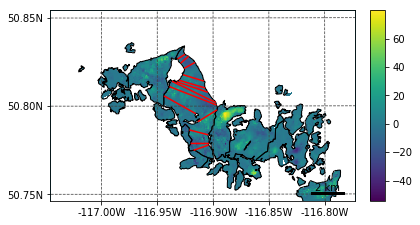

In [35]:
gates = 'conrad_flux_gates_17.shp'
points = fl_path + 'conrad_points_17gates_20m_b.shp' #'conrad_points_17gates.shp'
msk='conrad_2016_ice_msk_5m_glacieronly.tif'


vdir = '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/'#bedem5_spm2/'  
VX = vdir+ 'conrad_all_vx_3mdems_25m.tif' #'conrad_vx_spring_10m.tif' 
VY = vdir+ 'conrad_all_vy_3mdems_25m.tif' #'conrad_vy_spring_10m.tif'
# open GeoTIFF as array
#    msk='conrad_2016_ice_msk_5m_glacieronly.tif'
# VX = vdir1 + vdir[:-1] + '-F_vx.tif' 
# VY = vdir1+ vdir[:-1] + '-F_vy.tif' 
vx = salem.open_xr_dataset(VX)  #gdal.Open(vx).ReadAsArray()
vy = salem.open_xr_dataset(VY)#gdal.Open(vy).ReadAsArray()
vx = vx.to_array(name='vx')
# np.shape(vx[0]) remove index 1 i.e.: 1,2000,3000
vy = vy.to_array(name='vy')

msk = salem.open_xr_dataset(path+ msk) 
msk_reproj = vx.salem.transform(msk)  #note succeeding trying to use gdalwarp to go from 2955 --> 32611
msk = msk_reproj.to_array(name='msk')

gpr = salem.open_xr_dataset(fl_path + 'gpr_outline_25_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
gpr_reproj = vx.salem.transform(gpr)
gpr = gpr_reproj.to_array(name='gpr')

# H_opt = salem.GeoNetcdf(opt_path + 'Conrad101sw_MAE_optimized.nc')
H_opt = salem.open_xr_dataset(fl_path + 'opt_thick_101sw_MAE_5m.tif') #'Conrad101sw_MAE_optimized.nc'
#     pts = salem.read_shapefile(fl_path+pts)
gates = salem.read_shapefile(fl_path+gates)
topo = '/home/pelto/Desktop/lidar_cbt_analysis/conrad/20160912_conrad_dem1_clip_slave.tif'
dem = salem.open_xr_dataset(topo)
dem_reproj = vx.salem.transform(dem)
dem = dem_reproj.to_array(name='dem')


H_opt_reproj = vx.salem.transform(H_opt)
H_opt = H_opt_reproj.to_array(name='H_opt')

# ptsID.data[ptsID.data<-1000] = np.nan
# pts_ras.data[pts_ras.data<-1000] = np.nan
gpr.data[gpr.data<0] = np.nan
gpr.data[gpr.data==1.000] == 0.0   #not having any effect
vx.data[msk.data==0] = np.nan
vy.data[msk.data==0] = np.nan



#     # map extent
# grid = mercator_grid(center_ll=(-116.94, 50.80), extent=(10000, 9000)) ##zoomed out view
grid = vx.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(vx)

#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')


shpf = '/home/pelto/Desktop/lidar_cbt_analysis/conrad/Conrad/conrad_all_glaciers_2014.shp'
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1.5, color='r')
sm.visualize()
plt.show()

In [36]:
len(gpr.data[gpr.data==0.000])

0

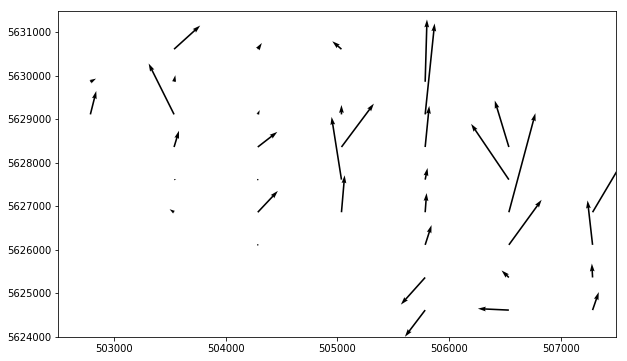

In [37]:
fig, ax = plt.subplots(1,1,figsize=(10,6))


df = salem.read_shapefile(fl_path + 'conrad_points_17gates_20m_wgs84_b.shp')

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]
# df['lon'] = df[4]
# df['lat'] = df[5]


xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

ax.scatter(df.lon, df.lat, s=10, c='r' )#c='depth',cmap='viridis', s=10, ax=ax);


X, Y = np.meshgrid(vx.coords['x'],vx.coords['y'])
U = vx.data[0]
V = vy.data[0]

# Q = ax.quiver(X, Y, U, V)#units='width', angles='uv') 
Q = ax.quiver(X[::30, ::30], Y[::30, ::30], U[::30, ::30], V[::30, ::30], units='xy')
ax.set_xlim(502500, 507500)
ax.set_ylim( 5624000, 5631500)
#     plt.quiver(vx.x, vx.y, vx.data ,vy.data)
plt.savefig(fl_path+ 'products/'+ 'conrad_16_17_quiver.pdf', dpi=300)

In [38]:
vns = ['vx',
       'vy',
       'gpr',
       'H_opt',
       'dem',
       ]

In [39]:
vns

['vx', 'vy', 'gpr', 'H_opt', 'dem']

In [40]:
M = xr.merge([vx,vy,gpr,H_opt, dem])

In [41]:
M.gpr.mean()

<xarray.DataArray 'gpr' ()>
array(130.06407, dtype=float32)

In [42]:
# for vn in vns:
#     Dis[vn] = M[vn][0].interp(x=('z', Dis.eNew), y=('z', Dis.nNew))

In [43]:
Dis

,Displacement,Elevation,Name,Year,azimuth,eNew,eOld,nNew,nOld,time_days,u,v,velocity
0,3.047950,1876.8,CST0,2015.0,48.990913,505139.8,505142.100,5631227.0,5631229.000,52.0,16.144231,14.038462,21.394265
1,6.621178,1968.0,CST1,2015.0,25.016893,504987.4,504990.200,5630982.0,5630988.000,52.0,19.653846,42.115385,46.475577
2,3.720215,2073.4,CST2,2015.0,-36.253838,505188.8,505186.600,5630627.0,5630630.000,52.0,-15.442308,21.057692,26.113048
3,11.605602,2174.6,CST3,2015.0,-18.591068,505544.7,505541.000,5629931.0,5629942.000,52.0,-25.971154,77.211538,81.462399
4,11.605602,1964.7,CST1,2016.0,18.591068,504991.1,504994.800,5630988.0,5630999.000,288.0,4.689236,13.940972,14.708489
5,5.381450,1874.8,CST0,2016.0,41.987212,505142.6,505146.200,5631227.0,5631231.000,288.0,4.562500,5.069444,6.820240
6,25.663983,2172.9,CST3,2016.0,-13.061551,505540.9,505535.100,5629941.0,5629966.000,288.0,-7.350694,31.684028,32.525533
7,1.220656,1871.1,CST0,2016.0,34.992020,505139.4,505140.100,5631225.0,5631226.000,70.0,3.650000,5.214286,6.364847
8,3.440930,2071.1,CST2A,2016.0,-54.462322,504995.0,504992.200,5630419.0,5630421.000,70.0,-14.600000,10.428571,17.941993
9,4.534314,2071.3,CST2B,2016.0,-48.576334,505077.6,505074.200,5630522.0,5630525.000,70.0,-17.728571,15.642857,23.643207


In [44]:
for vn in vns:
    df[vn] = M[vn][0].interp(x=('z', df.x), y=('z', df.y))

In [45]:
df

,distance,angle,id,len,geometry,min_x,max_x,min_y,max_y,lon,lat,x,y,vx,vy,gpr,H_opt,dem
0,0.000,61.368576,2,782.25,POINT (-116.9259650308174 50.82143882883324),-116.925965,-116.925965,50.821439,50.821439,-116.925965,50.821439,505214.918200,5.629971e+06,NaN,NaN,NaN,59.788406,2168.428348
1,20.000,61.368576,2,782.25,POINT (-116.925715678521 50.82152485234388),-116.925716,-116.925716,50.821525,50.821525,-116.925716,50.821525,505232.472606,5.629981e+06,NaN,NaN,NaN,59.788406,2159.793276
2,40.000,61.368576,2,782.25,POINT (-116.9254663253086 50.82161087532001),-116.925466,-116.925466,50.821611,50.821611,-116.925466,50.821611,505250.027012,5.629990e+06,0.107817,1.439740,NaN,60.424056,2165.335617
3,60.000,61.368576,2,782.25,POINT (-116.9252169711804 50.8216968977616),-116.925217,-116.925217,50.821697,50.821697,-116.925217,50.821697,505267.581418,5.630000e+06,-1.434663,1.632026,NaN,76.254214,2170.114734
4,80.000,61.368576,2,782.25,POINT (-116.9249676161363 50.82178291966868),-116.924968,-116.924968,50.821783,50.821783,-116.924968,50.821783,505285.135824,5.630009e+06,-5.554219,4.738540,NaN,115.151288,2170.010883
5,100.000,61.368576,2,782.25,POINT (-116.9247182601763 50.8218689410412),-116.924718,-116.924718,50.821869,50.821869,-116.924718,50.821869,505302.690231,5.630019e+06,-5.553228,5.883218,84.517634,121.214302,2166.426161
6,120.000,61.368576,2,782.25,POINT (-116.9244689033004 50.82195496187919),-116.924469,-116.924469,50.821955,50.821955,-116.924469,50.821955,505320.244637,5.630029e+06,-7.046411,8.319954,92.941674,121.214302,2162.763920
7,140.000,61.368576,2,782.25,POINT (-116.9242195455086 50.82204098218262),-116.924220,-116.924220,50.822041,50.822041,-116.924220,50.822041,505337.799043,5.630038e+06,-8.836712,11.519603,103.388598,121.214302,2159.471468
8,160.000,61.368576,2,782.25,POINT (-116.9239701868009 50.82212700195151),-116.923970,-116.923970,50.822127,50.822127,-116.923970,50.822127,505355.353449,5.630048e+06,-10.845297,13.244849,110.010120,121.214302,2157.562801
9,180.000,61.368576,2,782.25,POINT (-116.9237208271773 50.82221302118582),-116.923721,-116.923721,50.822213,50.822213,-116.923721,50.822213,505372.907855,5.630057e+06,-11.988732,15.316562,115.988619,121.214302,2156.697183


In [46]:
# grid.ij_coordinates
v_crs = check_crs(vx)
v_crs

<salem.Grid>
  proj: +init=epsg:32611 +units=m
  pixel_ref: center
  origin: upper-left
  (nx, ny): (770, 482)
  (dx, dy): (25.0, -25.0)
  (x0, y0): (496785.99999999994, 5633614.0)

In [47]:
df_agg = df[['id', 'len', 'distance', 'angle', 'geometry', 'lon', 'lat']].copy()
ii, jj = grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# # We trick by creating an index of similar i's and j's
# df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in (vx.coords['x'], vx.coords['y'])]
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

# Select
for vn in vns:
#     M_maksed = np.ma.masked_invalid(M[vn][0])
#     df_agg[vn] = .interp(x=('z', df_agg.i), y=('z', df_agg.j))
    df_agg[vn] = M[vn][0].isel(x=('z', df_agg.i), y=('z', df_agg.j))  

In [48]:
for vn in vns:
    Dis[vn] = M[vn][0].interp(x=('z', Dis.eNew), y=('z', Dis.nNew))

In [49]:
# df_dis = Dis.copy()
# ii, jj = grid.transform(df_dis.eNew, df_dis.nNew, crs=v_crs, nearest=True) #salem.wgs84
# df_dis['i'] = ii
# df_dis['j'] = jj
# # # We trick by creating an index of similar i's and j's
# # df_dis['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in (vx.coords['x'], vx.coords['y'])]
# df_dis['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
# df_dis = df_dis.groupby('ij').mean()
# # # Select
# for vn in vns:
#     df_dis[vn] = M[vn][0].isel(x=('z', df_dis.i), y=('z', df_dis.j))
# # for vn in vns:
# #     Dis[vn] = M[vn][0].isel(x=('z', Dis.eNew), y=('z', Dis.nNew))

In [50]:
D = df_agg[['id', 'len', 'distance', 'angle', 'lon', 'lat', 'vx', 'vy', 'gpr', 'H_opt']].copy() ##changed from df_agg for now
D

,id,len,distance,angle,lon,lat,vx,vy,gpr,H_opt
ij,,,,,,,,,,
0286_0215,6,2297.36,0.0,119.223461,-116.944057,50.805831,-4.553442,9.948083,1.000000,68.134018
0287_0216,6,2297.36,20.0,119.223461,-116.943810,50.805743,-3.442902,6.385530,NaN,68.134018
0288_0216,6,2297.36,50.0,119.223461,-116.943438,50.805611,-10.692575,5.594648,NaN,65.189636
0289_0217,6,2297.36,80.0,119.223461,-116.943067,50.805479,-17.346302,3.920565,NaN,65.189636
0290_0217,6,2297.36,100.0,119.223461,-116.942819,50.805391,-19.394047,0.563034,NaN,65.189636
0290_0218,6,2297.36,120.0,119.223461,-116.942572,50.805303,-18.821775,1.001492,NaN,65.189636
0291_0218,6,2297.36,140.0,119.223461,-116.942324,50.805216,-13.657518,2.183690,NaN,59.816944
0292_0218,6,2297.36,160.0,119.223461,-116.942076,50.805128,-6.068196,4.603932,NaN,59.816944
0293_0219,6,2297.36,190.0,119.223461,-116.941705,50.804996,-5.686188,3.744649,NaN,54.381569


In [51]:
import math
D['vz'] = np.sqrt(D.vx**2 + D.vy**2 )  # np.sqrt(U**2 + V**2 )

D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north


### calculate angle of flux gate
#try making a raster with footprint of vel. raster with FG angle as the value
# FG_alpha = pts_ras.data - 90.0 # calculate normal angle to flux gate 

#multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
D['vfg'] = np.abs(D.vz * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice
D['Qopt'] = D.vfg * 0.9 * 20. * D.H_opt     ## ice flux per slice *0.9 to est. depth-integrated velocity
D['a'] = 20. * D.H_opt #area per slice

In [52]:
import math
Dis['vz'] = np.sqrt(Dis.vx**2 + Dis.vy**2 )  # np.sqrt(U**2 + V**2 )

Dis['vzdir'] = np.arcsin(Dis.vx/Dis.vz) *180/math.pi #Disegrees from north
Dis.velocity[Dis.velocity>45.]= np.nan ## remove outliers

Dis['diff_vel'] = Dis.velocity - Dis.vz
Dis['diffP_vel'] = Dis.diff_vel / Dis.velocity
### calculate angle of flux gate
#try making a raster with footprint of vel. raster with FG angle as the value
# FG_alpha = pts_ras.Disata - 90.0 # calculate normal angle to flux gate 

#multiply velocity vector by cosine of angle between vector anDis flux gate (line or line segment)
# Dis['vfg'] = np.abs(Dis.vz * np.cos((Dis.vzdir-(Dis.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice
# Dis['Qopt'] = Dis.vfg * 0.9 * 20. * Dis.H_opt     ## ice flux per slice *0.9 to est. Disepth-integrateDis velocity
# Dis['a'] = 20. * Dis.H_opt #area per slice

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [53]:

mean = Dis.diff_vel.mean() #[Dis.Year==float(year)].mean()
std  = Dis.diff_vel.std()
meanP = Dis.diffP_vel.mean() #[Dis.Year==float(year)].mean()
print(mean, '+/-',std)
print(meanP)

6.149792141163362 +/- 7.552950520006117
0.2734714402570869


In [54]:
Dis.to_csv(fl_path+'conrad_Disp.csv')

In [28]:
Dis

,Displacement,Elevation,Name,Year,azimuth,eNew,eOld,nNew,nOld,time_days,...,velocity,vx,vy,gpr,H_opt,dem,vz,vzdir,diff_vel,diffP_vel
0,3.047950,1876.8,CST0,2015.0,48.990913,505139.8,505142.100,5631227.0,5631229.000,52.0,...,21.394265,-2.292271,5.912317,NaN,20.772923,1883.163975,6.341135,-21.191867,15.053130,0.703606
1,6.621178,1968.0,CST1,2015.0,25.016893,504987.4,504990.200,5630982.0,5630988.000,52.0,...,NaN,-3.067750,-4.870358,58.150002,47.749821,1980.203983,5.755995,-32.206079,NaN,NaN
2,3.720215,2073.4,CST2,2015.0,-36.253838,505188.8,505186.600,5630627.0,5630630.000,52.0,...,26.113048,-17.773937,-2.696767,78.430000,81.561424,2085.642090,17.977358,-81.372548,8.135690,0.311557
3,11.605602,2174.6,CST3,2015.0,-18.591068,505544.7,505541.000,5629931.0,5629942.000,52.0,...,NaN,-6.920131,25.552480,NaN,152.328259,2188.042586,26.472957,-15.153374,NaN,NaN
4,11.605602,1964.7,CST1,2016.0,18.591068,504991.1,504994.800,5630988.0,5630999.000,288.0,...,14.708489,-2.136337,-4.503037,NaN,47.749821,1978.030037,4.984102,-25.380657,9.724386,0.661141
5,5.381450,1874.8,CST0,2016.0,41.987212,505142.6,505146.200,5631227.0,5631231.000,288.0,...,6.820240,-2.368783,5.951752,NaN,20.685944,1882.666979,6.405817,-21.702433,0.414423,0.060764
6,25.663983,2172.9,CST3,2016.0,-13.061551,505540.9,505535.100,5629941.0,5629966.000,288.0,...,32.525533,-7.581559,23.709723,NaN,153.571793,2186.615278,24.892389,-17.732501,7.633145,0.234682
7,1.220656,1871.1,CST0,2016.0,34.992020,505139.4,505140.100,5631225.0,5631226.000,70.0,...,6.364847,-2.175766,5.735318,NaN,20.801917,1883.714424,6.134153,-20.774879,0.230694,0.036245
8,3.440930,2071.1,CST2A,2016.0,-54.462322,504995.0,504992.200,5630419.0,5630421.000,70.0,...,17.941993,-5.409291,6.828981,101.226003,56.938904,2085.390723,8.711798,-38.383028,9.230195,0.514446
9,4.534314,2071.3,CST2B,2016.0,-48.576334,505077.6,505074.200,5630522.0,5630525.000,70.0,...,23.643207,-8.762817,0.308298,108.769997,102.996040,2085.345818,8.768239,-87.985018,14.874968,0.629143


In [29]:
D.vzdir[D.ID==0].mean()

AttributeError: 'DataFrame' object has no attribute 'ID'

In [ ]:
Q_out= [0.,] #flux out per gate
cr_area = [0.,] # cross-section area per gate
vzdir = [0.,]

for n in range(D.ID.nunique()+1):
        Q_out.append(D.Qopt[D.ID==n].sum()) 
        cr_area.append(D.a[D.ID==n].sum())
        vzdir.append(D.vzdir[D.ID==n].mean())           
Q_in = [Q_out[1:]] #flux in per bin
Q_in = np.squeeze(Q_in)
# Q_in[]



FG = pd.DataFrame(list(zip(Q_out, Q_in, cr_area, vzdir)), columns=['Q_out', 'Q_in', 'cr_area', 'vzdir']) 

FG['vfg'] = FG.Q_out / FG.cr_area #net velocity per gate
FG['bin']=np.arange(0,12,1)
FG

In [ ]:
data = pd.read_csv(fl_path + 'Conrad_bins_17b.csv') #need dh_dt, area, field pts, n, mid elev (mean elev)
data.sort_values(by=['bin'],ascending=True, inplace=True) # sort by bin
data.set_index('bin', inplace=True) # set bin as index for sorting
data[0:4]

In [ ]:
FG_df =  pd.concat([FG, data], axis=1)
FG_df

In [ ]:
bb = FG_df.Q_out[6]+ FG_df.Q_out[7] - FG_df.Q_out[5]
bb

In [ ]:
FG_df['Q_net'] = FG_df.Q_in - FG_df.Q_out  #net flux per gate
# FG_df.Q_net[FG_df.bin==8] = FG_df.Q_out[FG_df.bin==9]+ FG_df.Q_out[FG_df.bin==10] - FG_df.Q_out[FG_df.bin==8]
FG_df.Q_net[6] = FG_df.Q_out[7]+ FG_df.Q_out[8] - FG_df.Q_out[6]
FG_df   #[0:4]

### import data per bin: height change, elevation, surface area, obs.SMB etc. 

In [ ]:
fb= Q_in[5] - Q_out[5]
fb

In [ ]:
FG_df['Q_netA']= FG_df.Q_net / FG_df.area 
FG_df['b_fg_h'] = FG_df.dh1617mean - FG_df.Q_netA
FG_df['b_fg_we'] = FG_df.rho/1000. * FG_df.b_fg_h
# FG_df.drop(FG_df.tail(1).index,inplace=True)
FG_df

In [ ]:
D['Agpr']=np.NaN
for n in range(D.ID.nunique()+1):

    for c in range(D.ID[D.ID==n].count()-1):
        idx=D[(D.ID==n)&(D.distance==D[D.ID==n].distance[c])].index
        
        if c==0:
            G= D.distance[D.ID==n][c+1] - D.distance[D.ID==n][c] * D.gpr[D.ID==n][c+1]*0.5 #area of triangle
        elif c==1:
            G= (D.distance[D.ID==n][c+1] - D.distance[D.ID==n][c])/2 * D.gpr[D.ID==n][c]
        elif c==len(D.ID[D.ID==n])-2: #
            G= (D.distance[D.ID==n][c] - D.distance[D.ID==n][c-1])/2 * D.gpr[D.ID==n]
        elif c==len(D.ID[D.ID==n])-1:  #last point in line
            G= D.distance[D.ID==n][c] + D.distance[D.ID==n][c+1] * D.gpr[D.ID==n][c-1]*0.5 #area of triangle
        else:
            G=(((D.distance[D.ID==n][c+1]-D.distance[D.ID==n][c])/2) + ((D.distance[D.ID==n][c] -
                    D.distance[D.ID==n][c-1])/2))* D.gpr[D.ID==n][c]  
       
        D.loc[idx,'Agpr']= G
#         D['Q_gpr'] = (D.vfg * 0.9 *D['Agpr'])
#     D['A'] = D.vfg[D.ID==n] * D.gpr[D.ID==n]

#calculate flux out using GPR thicknesses
D['Qo_gpr'] = D.Agpr * D.vfg * 0.9

In [ ]:
D.to_csv(fl_path+'conrad_junk.csv')

In [ ]:
Qo_gpr = [0.,] #flux out per gate
cr_area_gpr = [0.,] # cross-section area per gate
vzdir_gpr = [0.,]
n=0
for n in range(D.ID.nunique()):
        Qo_gpr.append(D.Qo_gpr[D.ID==n].sum()) 
        cr_area_gpr.append(D.Agpr[D.ID==n].sum())
        vzdir_gpr.append(D.vzdir[D.ID==n].mean())           
Qin_gpr = [Qo_gpr[1:]] #flux in per bin
Qin_gpr = np.squeeze(Qin_gpr)

In [ ]:
Qo_gpr

In [ ]:
FG_gpr = pd.DataFrame(list(zip(Qo_gpr, Qin_gpr, cr_area_gpr)), columns=['Qo_gpr', 'Qin_gpr', 'cr_area_gpr']) 
FG_gpr['bin'] = np.arange(0,11,1)#[0,1,2,3]
# FG_gpr['vfg'] = FG_gpr.Qo_gpr / FG_gpr.cr_area_gpr #net velocity per gate
# FG['bin']=np.arange(0,14,1)
FG_gpr

In [ ]:
FG_all = FG_df.merge(FG_gpr, on='bin')  

In [ ]:
FG_all

In [ ]:
FG_all['Q_net_gpr'] = FG_all.Qin_gpr - FG_all.Qo_gpr 
FG_all['Q_netA_gpr']= FG_all.Q_net_gpr / FG_all.area 
FG_all['b_fg_h_gpr'] = FG_all.dh1617mean - FG_all.Q_netA_gpr  #dh1516_mean
FG_all['b_fg_we_gpr'] = FG_all.rho/1000. * FG_all.b_fg_h_gpr
# FG_all.drop(FG_all.tail(1).index,inplace=True)
FG_all

In [ ]:
from scipy import stats
# import pylab

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [ ]:
a = FG_all.copy()
a

In [ ]:
[a.b_fg_we[a.b_fg_we < -8.]]

In [ ]:
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm


font = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 8}

plt.rc('font', **font)

fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(6,3.34))#3.34, 3.34))
# j,k=0,0    ## only define j if one row
n = 0
s= 15 #markersize
yr = 2017#2016, 2017, 2018
a = 0.7
color=['b', 'lime', 'green']
dt = pd.read_csv('/home/pelto/Desktop/ice_flux/Conrad/Conrad_bdot.csv')
##all_obs
x_ax_obs=dt[(dt.Year==yr)].Elev
y_ax_obs=dt[(dt.Year==yr)].Ba_surv

##obs by bin
# x_ax_obs=FG_df._elevmean  #FG_df.elev_mean
# y_ax_obs=FG_df.b_obs16#b_obs

# Drop unrealistic FG smb:
new = FG_all.copy()

new = new[new.b_fg_we >-8.]
new = new[new.b_fg_we_gpr >-8.]

x_ax_fg_gpr=new.elevmean
y_ax_fg_gpr=new.b_fg_we_gpr

x_ax_fg_opt=new.elevmean   #FG_df.elev_mean
y_ax_fg_opt=new.b_fg_we

for i in range(3):
    x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt]
    y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt]
    fit = np.polyfit(x[i],y[i],2)
    y_new = np.polyval(fit,x[i])
    ax.plot(x[i],y_new,c=color[i], linewidth=1.0, linestyle='--', alpha=a-0.1)

### observations of SMB
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(x_ax_obs),np.array(y_ax_obs))
ax.scatter(x_ax_obs,y_ax_obs,color='b', label='obs.', alpha=a, s=s,facecolor='')
ax.plot(x_ax_obs,slope*x_ax_obs+intercept, color='b',label='', alpha=a, linewidth=0.9)

slopeG, interceptG, r_valueG, p_valueG, std_errG = stats.linregress(np.array(x_ax_fg_gpr),np.array(y_ax_fg_gpr))
ax.scatter(x_ax_fg_gpr,y_ax_fg_gpr,color='lime', label='fg gpr.', alpha=a, s=s,facecolor='', marker='d')
ax.plot(x_ax_fg_gpr,slopeG*x_ax_fg_gpr+interceptG, color='lime',label='', alpha=a, linewidth=0.9)

# X = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt]
# Y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt]
# out=[]
# for i in range(3):
#      ## X usually means our input variables (or independent variables)
#      ## Y usually means our output/dependent variable
#     X_new = stm.add_constant(X[i]) ## let's add an intercept (beta_0) to our model
#     mod = stm.OLS(Y[i], X_new).fit()   #FG_all.b_fg_we_gpr, FG_all._elevmean) # stm.OLS(output, input)
#     predictions = mod.predict(X_new)
#     out.append(np.round(1000*mod.bse[1],2) )





#         ### flux gate from GPR thickness
#         slopeM, interceptM, r_valueM, p_valueM, std_errM = stats.linregress(np.array(x_ax_fg),np.array(y_ax_fg))
#         ax.scatter(x_ax_fg,y_ax_fg,color='r', label='fgel', alpha=a, s=s+2, facecolor='')
#         ax.plot(x_ax_fg,slopeM*x_ax_fg+interceptM, color='r', label='', alpha=a, linewidth=0.9)
#         ax.text(0.5, 0.1, ['$obs. slope:$', np.round(slope,4)], transform=ax.transAxes)
#         ax.text(0.5, 0.2, ['$FG. slope:$', np.round(slopeM,4)], transform=ax.transAxes)

#         ax.text(0.05, 0.9, year[n], transform=ax.transAxes, fontweight='bold')

###flux gate from optimized thickness
slopeM_opt, interceptM_opt, r_valueM_opt, p_valueM_opt, std_errM_opt = stats.linregress(np.array(
    x_ax_fg_opt),np.array(y_ax_fg_opt))
ax.scatter(x_ax_fg_opt,y_ax_fg_opt,color='g', label='fg opt.', alpha=a, s=s+2, facecolor='', marker='d')
ax.plot(x_ax_fg_opt,slopeM_opt*x_ax_fg_opt+interceptM_opt, color='g', label='', alpha=a, linewidth=0.9)
ax.axhline(linewidth=1, color='k', ls='--', alpha=a, zorder=0)

# ax.text(0.05, 0.9, 'All', transform=ax.transAxes, fontweight='bold')
txt='Obs. slope: ' + str(np.round(1000*slope,2))+ ' +/- ' + str(np.round(1000*std_err,2))
# txtO=
# txtG=
ax.text(0.5, 0.1, txt, transform=ax.transAxes)
ax.text(0.5, 0.15, (str('$FG ' + 'H_{opt}''slope:$')+ str(np.round(1000*slopeM_opt,2))+ '+/-' + str(np.round(1000*std_errM_opt,2))), transform=ax.transAxes)
ax.text(0.5, 0.2, ('$FG. gpr slope:$', np.round(1000*slopeG,2),'+/-', np.round(1000*std_errG,2)), transform=ax.transAxes)
#'$\frac{+}{-}$'

fig.subplots_adjust(bottom=0.12, top=0.98, hspace=0.1, left=0.07, right=0.99, wspace=0.05)#left=0.07, right=0.9,wspace=0.05, 
ax.legend(loc='best')#, bbox_to_anchor=(0, 0.42, 0.7, 0.5), labelspacing=0.2, handletextpad=0.1)
fig.text(0.01, 0.75, 'Mass balance (m w.e.)', rotation=90)
fig.text(0.45, 0.01, 'Elevation (m a.s.l.)')
plt.savefig(fl_path + 'products/' + 'conrad_bdot_2017_new.png', dpi=300) #+ Glacier[gl]
plt.show()

In [ ]:
obs

In [ ]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='2'
pylab.rcParams['ytick.major.pad']='2'

j,k = 0,0
n=0
# df_agg['area_opt'] = df_agg.thick_opt * 10 
a=0.8
letter='a','b','c','d'

obs = df_agg.copy()
obs.gpr[obs.ID==6]=np.nan
obs = obs.dropna(subset=['gpr'])   #[obs.gpr != np.nan]


fig, ax = plt.subplots(2,6, figsize=(12,4))
for i in range(D.ID.nunique()):
    
    # plot glacier surface
    ax[j,k].plot(df_agg[df_agg.ID==i].distance, (df_agg[df_agg.ID==i].dem), color='#43a2ca', alpha=a, label='Ice surf.')
    
    #plot gpr thickness gates
    gpr=(obs[obs.ID==i].dem)-(obs[obs.ID==i].gpr)
    gpr_mask=np.isfinite(gpr)
    ax[j,k].plot(obs[obs.ID==i].distance, gpr, marker='o'
                 , ms=2, ls='--', color='k', alpha=a, label='Obs. bed')
    
#         ax[j,k].set_ylim(((df_agg.elev[df_agg.ID_opt==i])-(df_agg[df_agg.ID_opt==i].thick_opt)+5).max(), -5)
    
    ##plot optimized thickness gates
    ax[j,k].plot(df_agg[df_agg.ID==i].distance, (df_agg[df_agg.ID==i].dem)-(df_agg[df_agg.ID==i].H_opt), 
                 ls='--', c='r', alpha=a, label='Model bed')  #marker='o')
    
    ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(50)) ##
#     ax[j,k].text(0.05, 0.05, letter[i], transform=ax[j,k].transAxes, fontweight='bold', fontsize=10, verticalalignment='center', horizontalalignment='center',)
    n += 1

    k += 1
    if n == 5: 
        j += 1
        k = 0  
         
    ax[0,4].legend(loc=1)
      
fig.text(0.01, 0.6, 'Altitude (m a.s.l.)', rotation=90)
fig.text(0.5, 0.01, 'Distance (m)')     
fig.subplots_adjust(bottom=0.085, top=0.98, left=0.05, right=0.99, wspace=0.22, hspace=0.15) 
plt.savefig(fl_path + 'products/' + 'Conrad_flux_gates_new.png', dpi=300)
plt.show()

# for i in range(4):
#     area=df_agg[df_agg.ID_opt==i].area_opt
#     area_total = area.sum()
#     print(area_total)        